<a href="https://colab.research.google.com/github/Gopika-K-G/ML-Internship/blob/main/flight_ticket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   FlightID    Airline DepartureAirport ArrivalAirport     DepartureDate  \
0         1      Delta              ORD            ORD  01-01-2024 00:00   
1         2  Southwest              ATL            ATL  01-01-2024 01:00   
2         3   American              JFK            ATL  01-01-2024 02:00   
3         4     United              ATL            DFW  01-01-2024 03:00   
4         5    JetBlue              ORD            ATL  01-01-2024 04:00   

   Distance  FlightDuration    Class  NumberOfStops  DaysUntilDeparture  \
0      3194            4.46    First              0                  89   
1       544            4.95    First              0                 211   
2      1847            3.73    First              1                 301   
3      2727            6.25  Economy              1                 164   
4      2721            1.23    First              2                 217   

  DayOfWeek  TicketPrice  
0    Monday      1478.37  
1    Monday      1703.66  
2    Monday

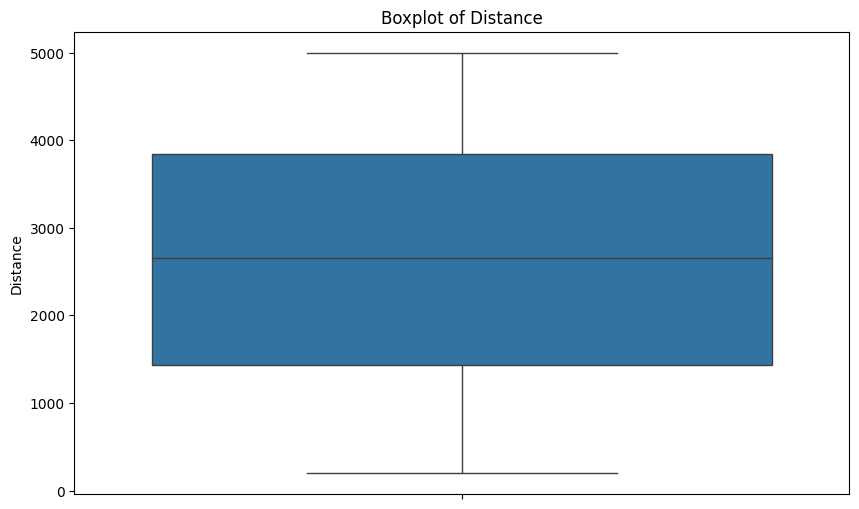

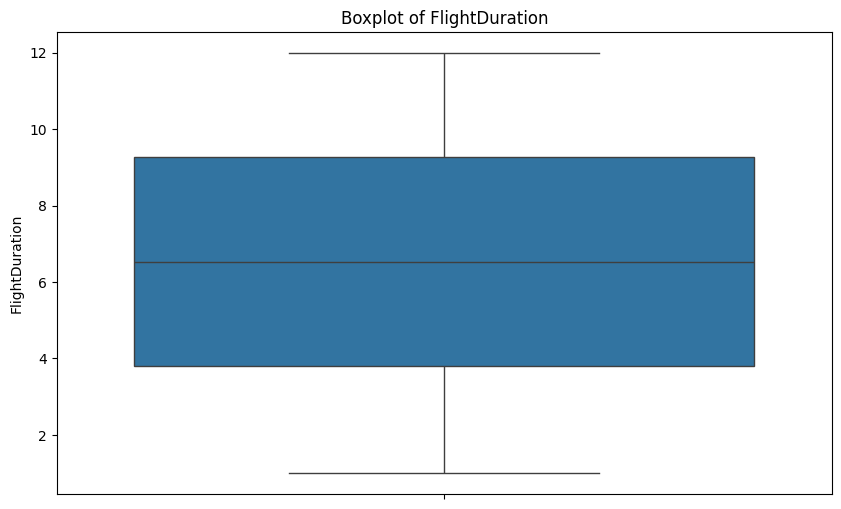

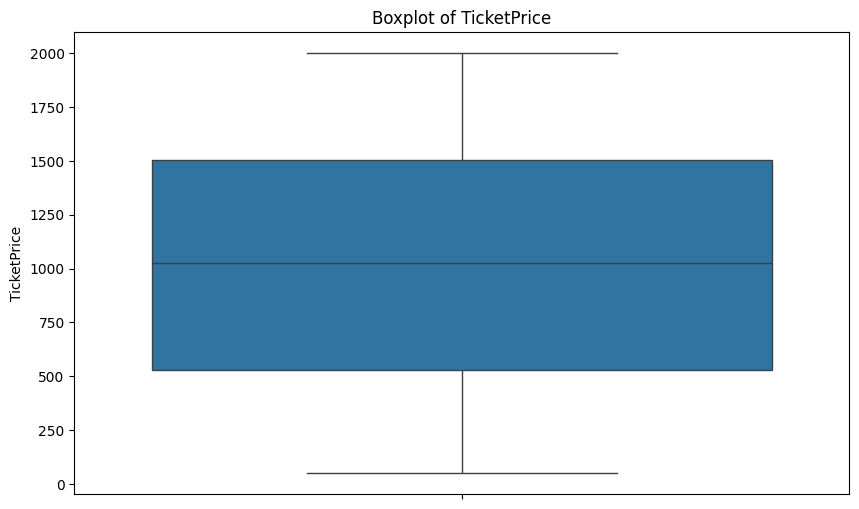

No outliers found.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Load the dataset
df = pd.read_csv('flight_ticket_dataset.csv')

# Check the first few rows
print(df.head())

# Get the summary of the dataset
print(df.info())

# Check for missing values
print(df.isnull().sum())

# Get summary statistics of numerical features
print(df.describe())

# Columns to check for outliers
columns_to_check = ['Distance', 'FlightDuration', 'TicketPrice']

# Plot boxplots for each column
for col in columns_to_check:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for each column
Q1 = df[columns_to_check].quantile(0.25)
Q3 = df[columns_to_check].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[((df[columns_to_check] < lower_bound) | (df[columns_to_check] > upper_bound)).any(axis=1)]

# Print outliers if found
if not outliers.empty:
    print("Outliers found:")
    print(outliers)
else:
    print("No outliers found.")

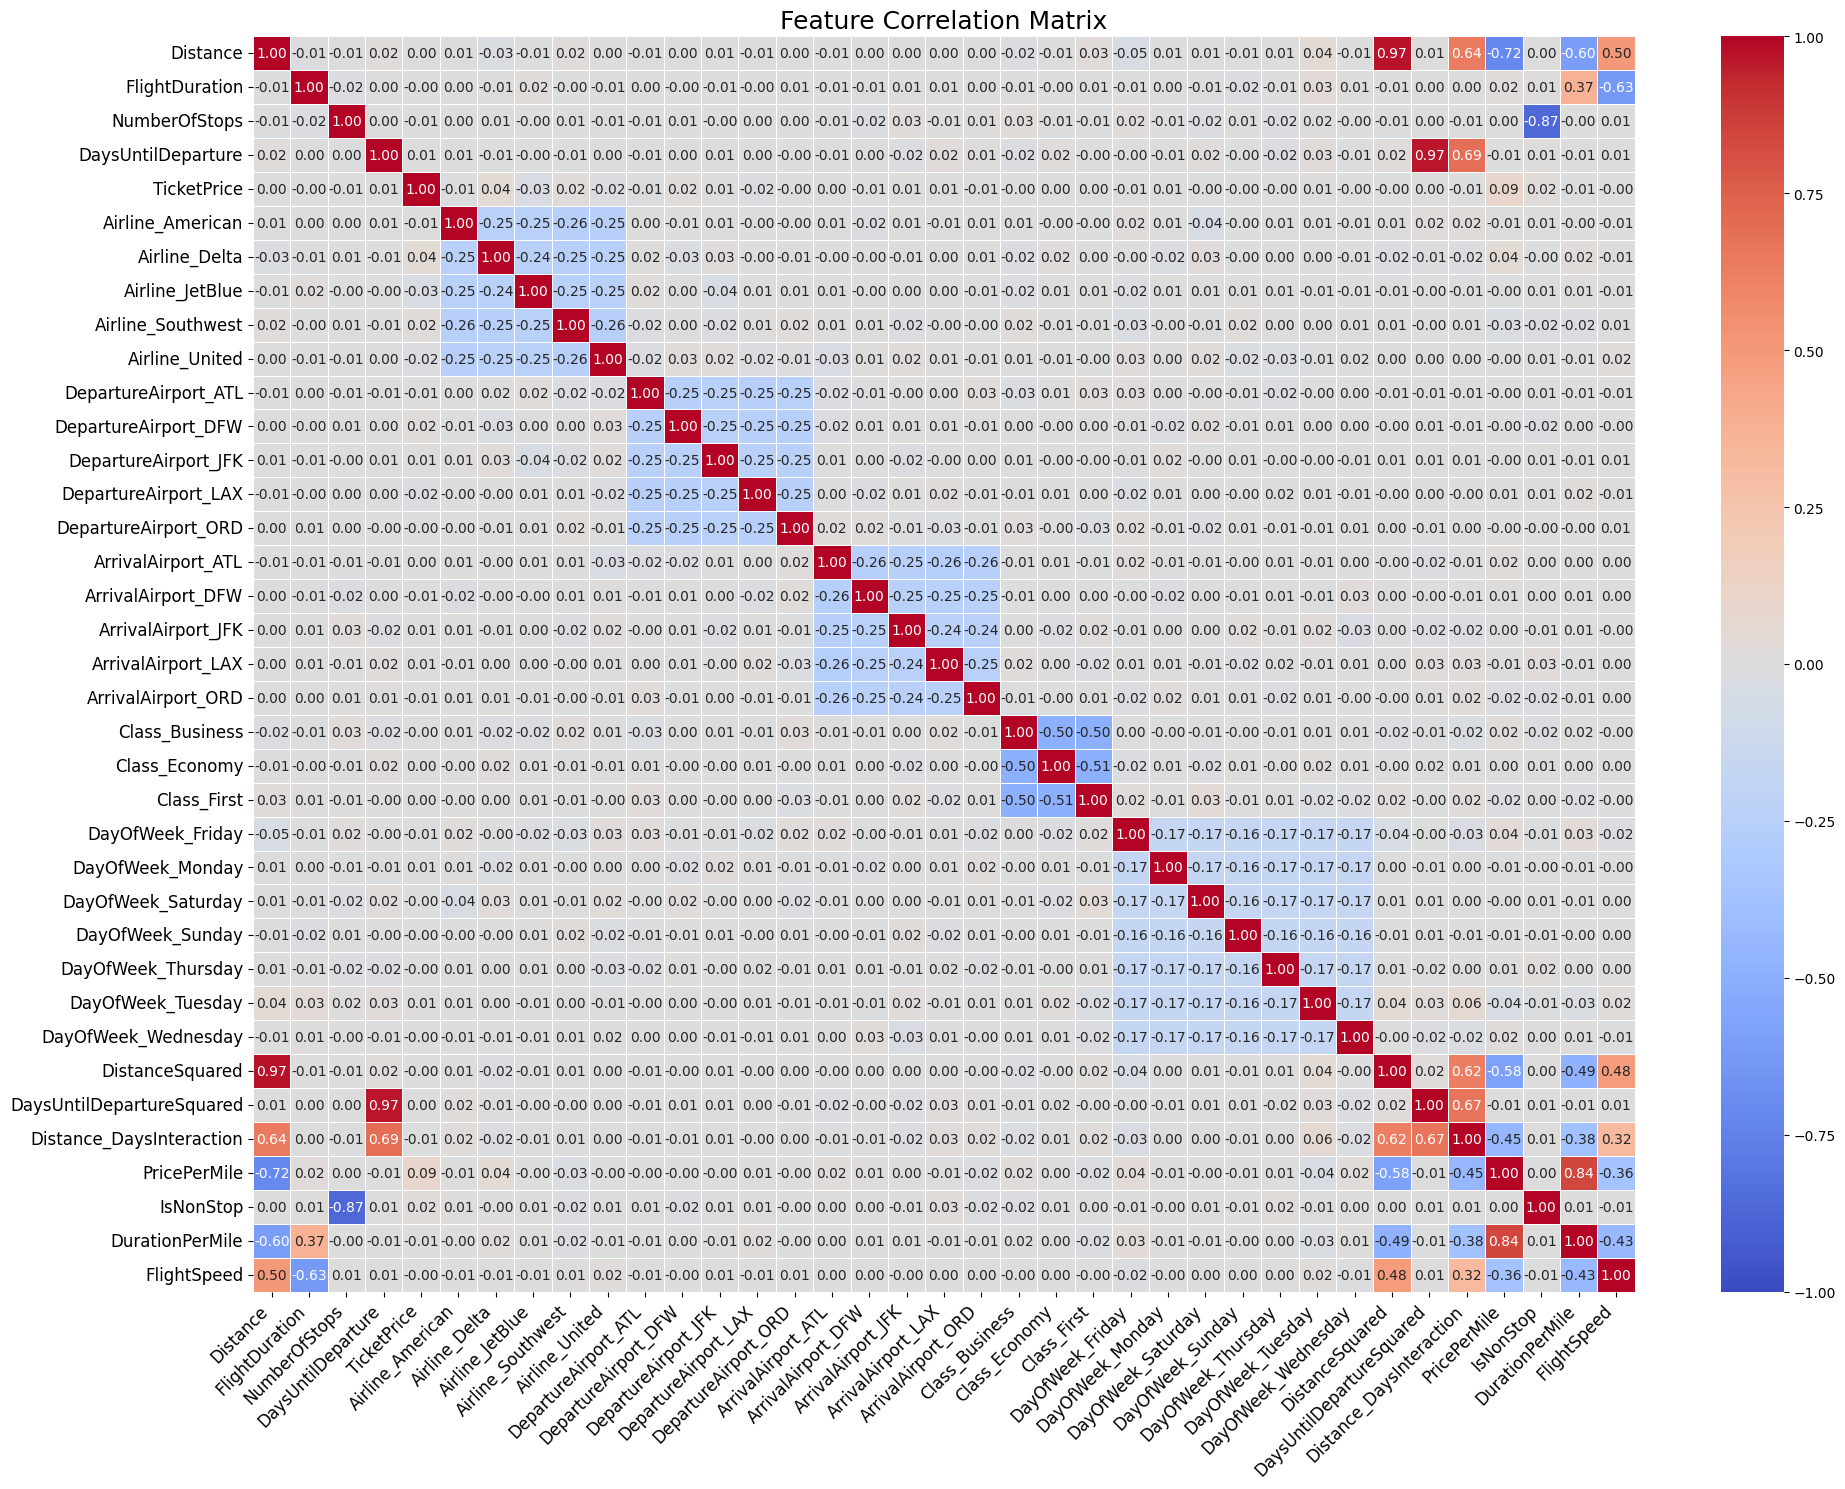

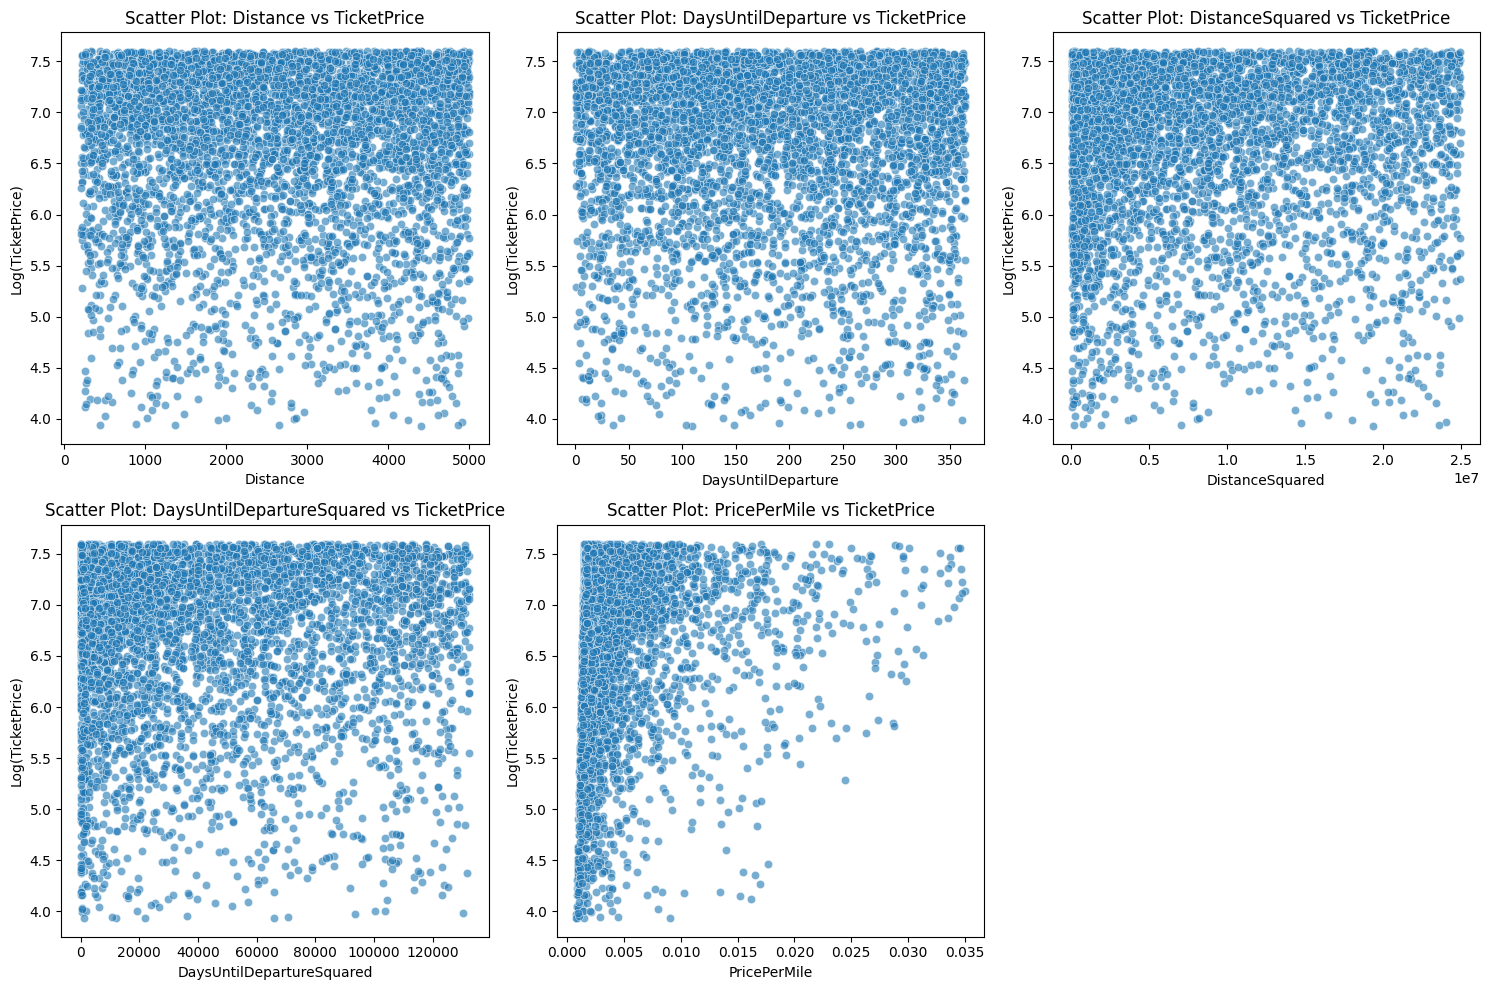

In [ ]:
# Drop the 'DepartureDate' and 'FlightID' columns since 'DaysUntilDeparture' contains the relevant information
df.drop(['DepartureDate', 'FlightID'], axis=1, inplace=True)

# Categorical columns to encode
categorical_columns = ['Airline', 'DepartureAirport', 'ArrivalAirport', 'Class', 'DayOfWeek']

# One-hot encode the categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_columns)

# Log transformation on the target variable to handle skewness
df_encoded['TicketPrice'] = np.log1p(df_encoded['TicketPrice'])

# Feature Engineering
# Adding polynomial and interaction features
df_encoded['DistanceSquared'] = df_encoded['Distance'] ** 2  # Squared feature
df_encoded['DaysUntilDepartureSquared'] = df_encoded['DaysUntilDeparture'] ** 2  # Squared feature
df_encoded['Distance_DaysInteraction'] = df_encoded['Distance'] * df_encoded['DaysUntilDeparture']  # Interaction feature

# Adding new features
#1.
df_encoded['PricePerMile'] = df_encoded['TicketPrice'] / df_encoded['Distance']  # Ticket Price per Mile

# 2. Stop Indicator (Binary)
df_encoded['IsNonStop'] = df['NumberOfStops'].apply(lambda x: 1 if x == 0 else 0)

# 3. Flight Duration per Distance
df_encoded['DurationPerMile'] = df_encoded['FlightDuration'] / df_encoded['Distance']

# 4. Flight Speed
df_encoded['FlightSpeed'] = df_encoded['Distance'] / df_encoded['FlightDuration']

# Check for NaN values and remove rows if any
if df_encoded.isnull().sum().any():
    print("NaN values found. Removing rows with NaN values...")
    df_encoded = df_encoded.dropna()

# Correlation matrix to identify multicollinearity
plt.figure(figsize=(20, 15))  # Increase figure size for better visibility
corr_matrix = df_encoded.corr()

# Generate a heatmap with annotations and rounded values
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt='.2f', annot_kws={"size": 10}, linewidths=0.5, vmin=-1, vmax=1)

plt.title("Feature Correlation Matrix", fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better visibility
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Generate scatter plots to analyze relationships with TicketPrice
features_to_plot = ['Distance', 'DaysUntilDeparture', 'DistanceSquared', 'DaysUntilDepartureSquared', 'PricePerMile']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_plot):
    plt.subplot(2, 3, i + 1)
    sns.scatterplot(data=df_encoded, x=feature, y='TicketPrice', alpha=0.6)
    plt.title(f'Scatter Plot: {feature} vs TicketPrice')
    plt.xlabel(feature)
    plt.ylabel('Log(TicketPrice)')

plt.tight_layout()
plt.show()


Random Forest:

Feature Types:
 Distance                     float64
FlightDuration               float64
NumberOfStops                float64
DaysUntilDeparture           float64
Airline_American                bool
Airline_Delta                   bool
Airline_JetBlue                 bool
Airline_Southwest               bool
Airline_United                  bool
DepartureAirport_ATL            bool
DepartureAirport_DFW            bool
DepartureAirport_JFK            bool
DepartureAirport_LAX            bool
DepartureAirport_ORD            bool
ArrivalAirport_ATL              bool
ArrivalAirport_DFW              bool
ArrivalAirport_JFK              bool
ArrivalAirport_LAX              bool
ArrivalAirport_ORD              bool
Class_Business                  bool
Class_Economy                   bool
Class_First                     bool
DayOfWeek_Friday                bool
DayOfWeek_Monday                bool
DayOfWeek_Saturday              bool
DayOfWeek_Sunday                bool
DayOfWeek_Thursday    

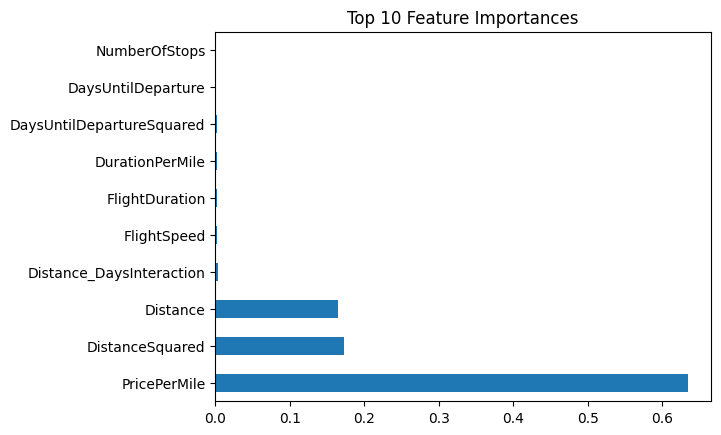

In [ ]:
# Columns to scale
columns_to_scale = df_encoded.select_dtypes(include=['float64', 'int64']).columns

# Use MinMaxScaler instead of StandardScaler
scaler = MinMaxScaler()
df_encoded[columns_to_scale] = scaler.fit_transform(df_encoded[columns_to_scale])

# Define features (X) and target variable (y)
X = df_encoded.drop('TicketPrice', axis=1)  # Features
y = df_encoded['TicketPrice']  # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure all features are numeric
print("Feature Types:\n", X_train.dtypes)

# Define the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None],  # 'auto' is deprecated, use 'sqrt', 'log2', or None
    'bootstrap': [True, False]
}

# Set up the GridSearchCV with error_score
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5,
                           verbose=1, n_jobs=-1, error_score='raise')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validated MSE: {-best_score}")

# Now use the best parameters to fit the final Random Forest model
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

# Convert predictions back to original scale (inverse log transformation)
y_pred_original = np.expm1(y_pred)
y_test_original = np.expm1(y_test)

# Print the evaluation metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared Score: {r_squared}")

# Cross-validated MSE
cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Cross-validated MSE:", -cv_scores.mean())

# Feature importance
importance = best_rf_model.feature_importances_
feature_importance = pd.Series(importance, index=X_train.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.show()


XGBoost Model:

Feature Types:
 Distance                     float64
FlightDuration               float64
NumberOfStops                float64
DaysUntilDeparture           float64
Airline_American                bool
Airline_Delta                   bool
Airline_JetBlue                 bool
Airline_Southwest               bool
Airline_United                  bool
DepartureAirport_ATL            bool
DepartureAirport_DFW            bool
DepartureAirport_JFK            bool
DepartureAirport_LAX            bool
DepartureAirport_ORD            bool
ArrivalAirport_ATL              bool
ArrivalAirport_DFW              bool
ArrivalAirport_JFK              bool
ArrivalAirport_LAX              bool
ArrivalAirport_ORD              bool
Class_Business                  bool
Class_Economy                   bool
Class_First                     bool
DayOfWeek_Friday                bool
DayOfWeek_Monday                bool
DayOfWeek_Saturday              bool
DayOfWeek_Sunday                bool
DayOfWeek_Thursday    

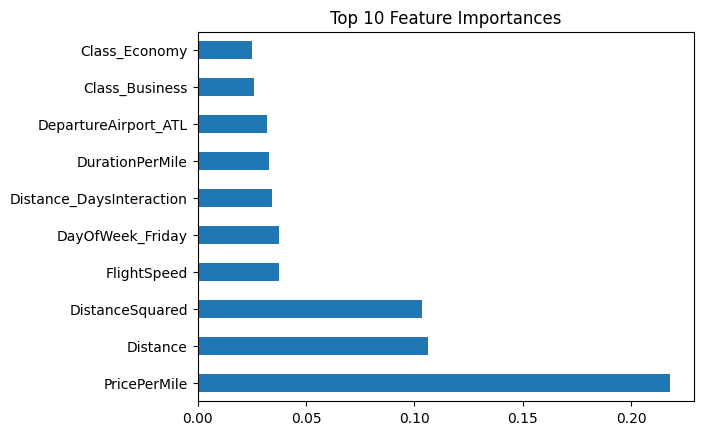

In [14]:
# Columns to scale
columns_to_scale = df_encoded.select_dtypes(include=['float64', 'int64']).columns

# Use MinMaxScaler instead of StandardScaler
scaler = MinMaxScaler()
df_encoded[columns_to_scale] = scaler.fit_transform(df_encoded[columns_to_scale])

# Define features (X) and target variable (y)
X = df_encoded.drop('TicketPrice', axis=1)  # Features
y = df_encoded['TicketPrice']  # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure all features are numeric
print("Feature Types:\n", X_train.dtypes)

# Define the XGBoost model
xgb_model = XGBRegressor()

# Hyperparameter grid with regularization
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 5],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'reg_alpha': [0.01, 0.1],
    'reg_lambda': [1, 10]
}

# Set up the GridSearchCV with error_score
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5,
                           verbose=1, n_jobs=-1, error_score='raise')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validated MSE: {-best_score}")

# Now use the best parameters to fit the final model
best_model = XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

# Convert predictions back to original scale (inverse log transformation)
y_pred_original = np.expm1(y_pred)
y_test_original = np.expm1(y_test)

# Print the evaluation metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared Score: {r_squared}")

# Cross-validated MSE
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Cross-validated MSE:", -cv_scores.mean())

# Feature importance
importance = best_model.feature_importances_
feature_importance = pd.Series(importance, index=X_train.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.show()
